In [1]:
import json
import pickle
from urllib.request import urlopen
import pandas as pd
import numpy as np
from math import pi
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

# set parameters
# figure color
colors = {'outdoors-adventure': [135/255,196/255,79/255,1],
          'sports-fitness': [237/255,177/255,51/255,1],
          'social': [228/255,89/255,245/255,1],
          'career-business': [39/255,65/255,107/255,1], 
          'tech': [94/255, 94/255, 94/255,1]}
# datetime 
years = [str(year) for year in range(2008,2019)]
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
hours = [f'{i:02d}' for i in range(0,24)]
datetime_columns = {'year': years,
                    'weekday': weekdays,
                    'month': months,
                    'hour': hours}

In [2]:
# group categories with similar topic together
# category information: id & shortname
category_url = 'https://api.meetup.com/2/categories?offset=0&format=json&photo-host=public&page=40&order=shortname&desc=false&sig_id=259262097&sig=e9836776ae4d86d8dbeee77cf85d5df674f367fb'
with urlopen(category_url) as response:
    source = response.read()
category_items = json.loads(source)['results']
# create dictionary (key: category_id, value: category_name)
category = {}
for item in category_items:
    category[item['id']] = item['shortname']

# category topics
topic_category_url = 'https://api.meetup.com/find/topic_categories?photo-host=public&sig_id=259262097&sig=9f9f1b9fc0d13775e271ae5bed13979f172c1390'
with urlopen(topic_category_url) as response:
    source = response.read()
topic_category_items = json.loads(source)
# create dictionary (key: category_id, value: topic_name)
category_topic = {}
for topic_item in topic_category_items:
    for category_item in topic_item['category_ids']:
        category_topic[category_item] = topic_item['shortname']

# update information of the mappings between categories and topics
categoryID_topic_map = category.copy()
categoryID_topic_map.update(category_topic)


In [3]:
# recode variables
# groups
df_groups = pd.read_pickle('df_groups')
df_groups['topic'] = df_groups['category_id'].map(categoryID_topic_map)
group_topic_map = {key: value for key, value in zip(df_groups.id, df_groups.topic)}
group_url_topic_map = {key: value for key, value in zip(df_groups.urlname, df_groups.topic)}
# save
with open('group_id_topic_map.pkl', 'wb') as f:
    pickle.dump(group_topic_map, f)
with open('group_url_topic_map.pkl', 'wb') as f:
    pickle.dump(group_url_topic_map, f)

# events
df_events = pd.read_pickle('df_events')
df_events['topic'] = df_events['group_id'].map(group_topic_map)

# datetime transformation
df_events['time'] =  pd.to_datetime(df_events['time'], unit='ms').dt.tz_localize('GMT').dt.tz_convert('US/Eastern')
# because there were fewer entries in early years, the events occurred before 2008 (inclusive) were aggregated
df_events['year'] = df_events['time'].dt.year
before_2008_mask = df_events['year'] <= 2008
df_events.loc[before_2008_mask, 'year'] = 2008

df_events['month'] = df_events['time'].dt.month
df_events['hour'] = df_events['time'].dt.hour
df_events['weekday'] = df_events['time'].dt.weekday
df_events['weekend_events'] = df_events['weekday'] >= 5
df_events.loc[df_events['rating_count']==0,'rating_average']= np.nan
df_events['length'] = [dur/3600000 if dur != 'nan' else np.nan for dur in df_events['duration']]

# remove the topics with 
event_cutoffN = 1000
eventN = df_events.topic.value_counts(ascending=False)
selected_topics = eventN.loc[eventN > event_cutoffN].index
topic_mask = df_events['topic'].isin(list(selected_topics))
top5_topics = list(eventN[:5].index)
df_events = df_events.loc[topic_mask, :]

In [4]:
# examine the distribution of event occurance for weeks,months,and hours
# topic counts
events_topic_counts = pd.Series(df_events['topic'].value_counts())
def gen_crosstab_df(cross_item):
    tab = pd.crosstab(df_events['topic'], df_events[cross_item])
    tab = pd.DataFrame([tab[col]/events_topic_counts for col in tab.columns]).T
    # tab = pd.DataFrame([tab[col] for col in tab.columns]).T
    tab.columns = datetime_columns[cross_item]
    return tab

# weekday/month/hour occurance pattern
topic_cross_year = gen_crosstab_df('year')
topic_cross_weekday = gen_crosstab_df('weekday')
topic_cross_month = gen_crosstab_df('month')
topic_cross_hour = gen_crosstab_df('hour')

# T
sorted_topics = list(events_topic_counts.index)
df_popular_topics = pd.DataFrame({'topic':sorted_topics , 'popularity': list(range(1, len(sorted_topics)+1))})
df_popular_topics = df_popular_topics.set_index('popularity')

In [5]:
topic_cross_season = pd.DataFrame()
topic_cross_month.loc[:,'Mar':'May'].sum(axis = 1)
topic_cross_season['spring'] = topic_cross_month.loc[:,'Mar':'May'].sum(axis = 1)
topic_cross_season['summer'] = topic_cross_month.loc[:,'Jun':'Aug'].sum(axis = 1)
topic_cross_season['autumn'] = topic_cross_month.loc[:,'Sep':'Nov'].sum(axis = 1)
topic_cross_season['winter'] = topic_cross_month.loc[:,['Dec','Jan', 'Feb']].sum(axis = 1)
seasonal_dependent_topics = list(topic_cross_season.std(axis = 1).sort_values(ascending = False)[:3].index)
seasonal_independent_topics = list(topic_cross_season.std(axis = 1).sort_values()[:3].index)

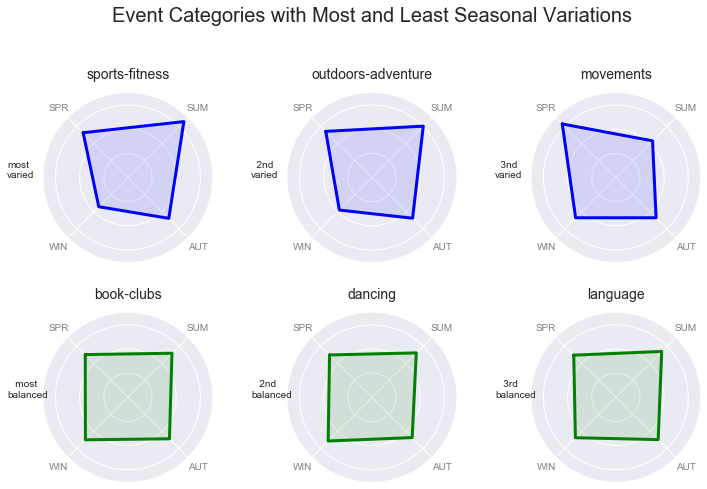

In [6]:
colors = ['b', 'b', 'b', 'g', 'g', 'g']
texts = ['most\nvaried', '  2nd\nvaried', '  3nd\nvaried', '   most\nbalanced', '   2nd\nbalanced', '   3rd\nbalanced']
# seasonal occurance
def draw_seasonal_occurance_pattern(j,topics):
    # adapted from https://python-graph-gallery.com/390-basic-radar-chart/
    
    ax = plt.subplot(2,3,j+1, polar=True)
    # If you want the first axis to be on top:
    ax.set_theta_offset(3*pi / 4)
    ax.set_theta_direction(-1)

    
    #plt.subplot(111, polar=True)
    df = topic_cross_season.loc[topics,:]
    # print(df)
    
    # number of variable
    categories=list(df.columns)
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], ['SPR', 'SUM', 'AUT', 'WIN'], size = 10, color = [0,0,0,0.5])
    
    # Draw ylabels
    #ax.set_rlabel_position(0)
    plt.yticks([0.1,0.2,0.3], ["","",""], size=5, color = [1,1,1,1])
    plt.ylim(0,0.35)

    # Plot data
    for i in range(len(topics)):
        #values = df.values.flatten().tolist()
        values = df.iloc[i,:].values.flatten().tolist()
        values += values[:1]
        plt.plot(angles, values, linewidth=3, linestyle='solid',color = colors[j])
        # Fill area
        ax.fill(angles, values, alpha=0.1,color = colors[j])
        ax.text(x = 7*pi/4, y = 0.5, s = texts[j])
        
    plt.title(s = topic, fontsize = 14)
    # plt.legend(topics)
    #plt.subplot(122)
    #plt.legend(popular_topics)
    
    return plt

fig,axes = plt.subplots(2, 5, figsize=(16, 8), sharey=True)
topic_list = seasonal_dependent_topics + seasonal_independent_topics
for i, topic in enumerate(topic_list):
    draw_seasonal_occurance_pattern(i,[topic_list[i]])
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, hspace = 0.3)
#plt.text(0.5,2,'test',fontsize = 16)
plt.suptitle('Event Categories with Most and Least Seasonal Variations',x=0.5, y=0.95,  fontsize = 20)
# plt.suptitle('Events with most seasonal variation',x=0.45, y=0.5,  fontsize = 20)
plt.show()


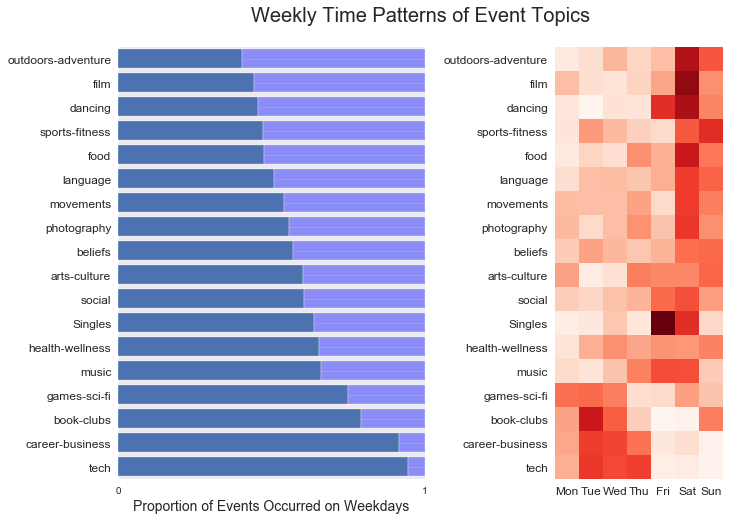

In [9]:
topicN = len(selected_topics)

weekends_prob = df_events[['topic', 'weekend_events']].groupby('topic').mean()
weekends_prob['weekday_events'] = 1 - weekends_prob['weekend_events']
weekends_prob.sort_values('weekend_events', ascending=True, inplace=True)


f, axes = plt.subplots(figsize=(12, 8))

plt.subplot(122)
plt.imshow(topic_cross_weekday.loc[reversed(weekends_prob.weekday_events.index),:], cmap = 'Reds')
plt.yticks(list(range(topicN)), reversed(weekends_prob.index), fontsize = 12)
plt.xticks(list(range(7)), weekdays, fontsize = 12)
plt.grid(False)


r = list(range(topicN))

plt.subplot(121)
# Create orange Bars
plt.barh(r, weekends_prob.weekday_events, edgecolor='white')
# Create blue Bars
plt.barh(r, weekends_prob.weekend_events, left= weekends_prob.weekday_events, edgecolor='white', color = [0,0,1,0.4])
 
# Custom x axis
plt.yticks(list(range(topicN)), weekends_prob.index, fontsize = 12)
plt.xticks(list(range(7)))
plt.xlim(0,1) 
plt.xlabel('Proportion of Events Occurred on Weekdays', fontsize = 14)
plt.ylim(-0.5,topicN - 0.5)
#plt.title('Proportion of Events Occurred on Weekdays', fontsize = 14)


plt.subplots_adjust(left=0.1, bottom=0.1, right=0.88, top=0.85,
                wspace=0.2)
plt.suptitle('Weekly Time Patterns of Event Topics',x=0.45, y=0.92,  fontsize = 20)
plt.show()
# Show graphic


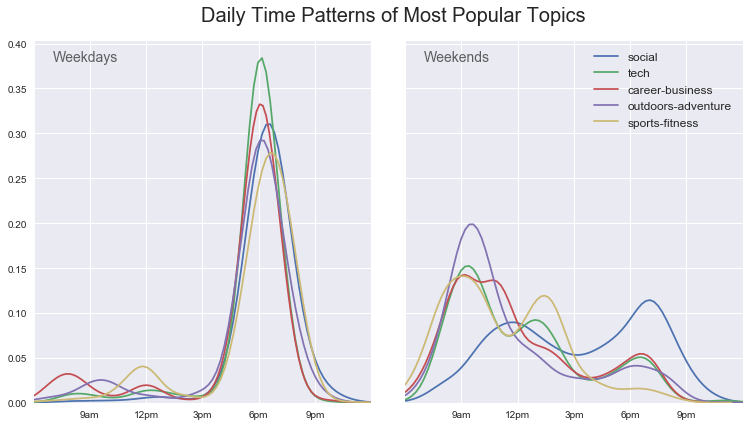

In [8]:
# Daily Occurance pattern (within 24 hours in one day, separated for weekdays and weekends)
dark_gray = [0,0,0,0.6]

f, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
sns.despine(left=True)

plt.xlim(6,24);
for i,topic in enumerate(top5_topics):
    sns.kdeplot(df_events.loc[(df_events['weekday'] < 5) & (df_events['topic']== topic),'hour'], bw = 0.8, legend = False, ax=axes[0])
axes[0].set_xlim(6,24);
axes[0].text(7,0.38,'Weekdays', fontsize = 14, color = dark_gray)

for i,topic in enumerate(top5_topics):
    sns.kdeplot(df_events.loc[(df_events['weekday'] >= 5) & (df_events['topic']== topic),'hour'], bw = 0.8, ax=axes[1])
axes[1].set_xlim(6,24);
axes[1].legend(top5_topics, fontsize = 12);
axes[1].text(7,0.38,'Weekends', fontsize = 14, color = dark_gray)

plt.setp(axes, xticks = [6,9,12,15,18,21], xticklabels = ["","9am",'12pm','3pm','6pm','9pm','']);
# 
plt.tight_layout()
plt.subplots_adjust(left=0, wspace=0.1, top=0.9)
plt.suptitle('Daily Time Patterns of Most Popular Topics', fontsize=20);